In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

In [4]:
# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

In [5]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')

R2: 0.7134


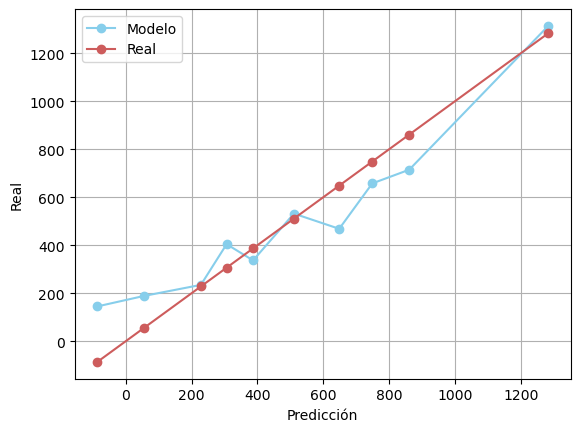

In [8]:
calibracion(y_pred, y_test, 10)

## Tensorflow

In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [54]:
# Custom R² metric function
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.2),  # Dropout layer

    Dense(64, activation='tanh'),  # Second hidden layer
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.1),  # Dropout layer

    Dense(128, activation='relu'),  # Second hidden layer
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.1),  # Dropout layer

    Dense(1)  # Output layer (regression)
])

# Compile the model with Adam optimizer and Mean Squared Error (MSE) loss
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=[r2_metric])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
pred_tf = model.predict(X_test)
pred_tf = pred_tf.flatten()

r2 = r2_score(y_test, pred_tf)
print(f'R² Score: {r2:.4f}')

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 460305.7812 - r2_metric: -1.8938 - val_loss: 421134.5312 - val_r2_metric: -1.3436
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 463944.4375 - r2_metric: -1.4795 - val_loss: 401286.8750 - val_r2_metric: -1.2268
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 454561.6250 - r2_metric: -1.4869 - val_loss: 385917.5938 - val_r2_metric: -1.1341
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 399688.9375 - r2_metric: -1.6548 - val_loss: 365774.0625 - val_r2_metric: -1.0148
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 407575.1250 - r2_metric: -1.5753 - val_loss: 358583.3125 - val_r2_metric: -0.9777
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 385942.3125 - r2_metric: -1.0335 - val_loss: 321964.4375 - val_r2_metric: -0.7678
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 414638.6250 - r2_metric: -1.2073 - val_loss: 323025.9375 - val_r2_metric: -0.7847
Epoch 8/100
7/7 ━━━━━━━━━━

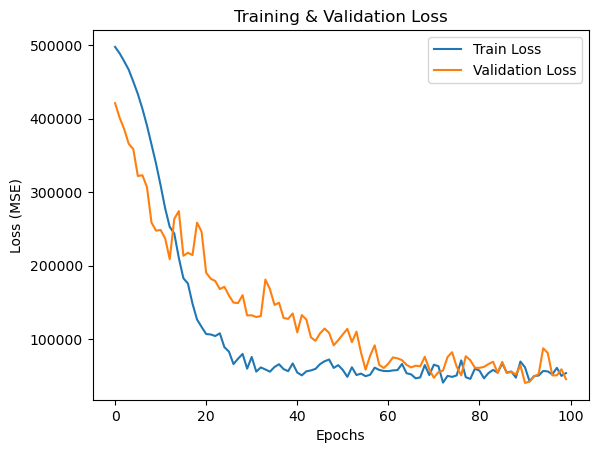

In [55]:
# Extract loss history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


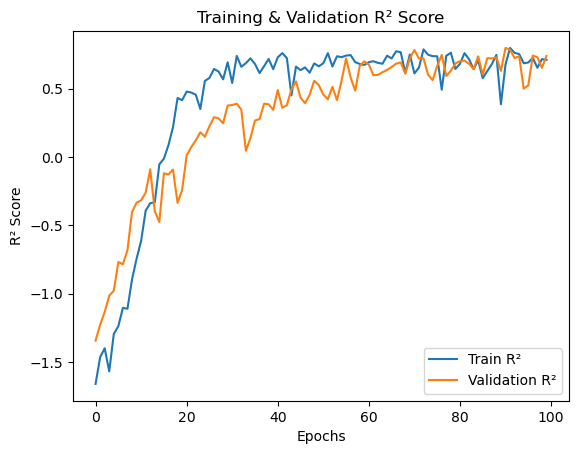

In [56]:
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('Training & Validation R² Score')
plt.legend()
plt.show()

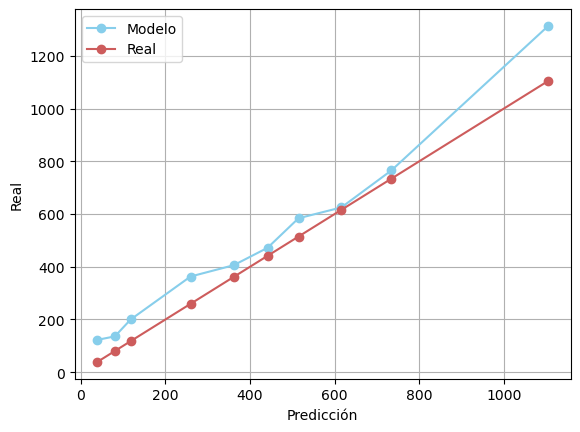

In [57]:
calibracion(pred_tf, y_test, 10)

## Save model

In [ ]:
#model.save('exam1.keras')

In [22]:
loaded_model = tf.keras.models.load_model('exam1.keras', custom_objects={'r2_metric': r2_metric})
predictions = loaded_model.predict(X_test).flatten()
r2_score(y_test, predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


0.7930205099033008

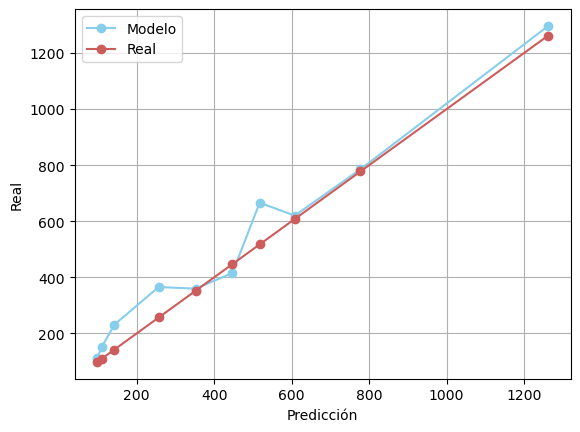

In [26]:
calibracion(predictions, y_test, 10)